In [2]:
import pandas
import pyreadr
import numpy as np
from datetime import datetime


In [3]:
result = pyreadr.read_r('/data/IDEA_DeFi_Research/Data/Lending_Protocols/Aave/V2/Mainnet/transactions.rds')

In [5]:
df = result[None]
df['DateTime'] = df['timestamp'].transform(lambda x: datetime.fromtimestamp(x))
df.head()


,id,type,timestamp,user,userAlias,onBehalfOf,onBehalfOfAlias,pool,reserve,amount,...,priceInUsd,borrowRateModeTo,borrowRateModeFrom,stableBorrowRate,variableBorrowRate,target,totalFee,version,deployment,DateTime
0,0xc70f4c3f447f6a88e9fbb87ac1394b589e469ee57dda...,borrow,1.606841e+09,0xbd723fc4f1d737dcfc48a07fe7336766d34cad5f,Rocky Kuebler,0xbd723fc4f1d737dcfc48a07fe7336766d34cad5f,Rocky Kuebler,0xb53c1a33016b2dc2ff3653530bff1848a515c8c5,DAI,1.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,V2,Mainnet,2020-12-01 11:46:58
1,0x1ee3db904548c16d2ed3572f3d9894652e031facc8fa...,borrow,1.606902e+09,0x21d05071ca08593e13cd3afd0b4869537e015c92,Odaly Chihuahua-Tovar,0x21d05071ca08593e13cd3afd0b4869537e015c92,Odaly Chihuahua-Tovar,0xb53c1a33016b2dc2ff3653530bff1848a515c8c5,DAI,1.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,V2,Mainnet,2020-12-02 04:34:18
2,0x1e8f85330edc5005ead7a7ae8c418fbb64df726d4ffc...,borrow,1.606905e+09,0x39d637737cc76c5849a52c7d3b872a1eb22aa71c,Stephon Wal,0x39d637737cc76c5849a52c7d3b872a1eb22aa71c,Stephon Wal,0xb53c1a33016b2dc2ff3653530bff1848a515c8c5,LINK,1.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,V2,Mainnet,2020-12-02 05:24:50
3,0x43136c7aba13c072bb19ed88f8eadf859f0bfb994b42...,borrow,1.606913e+09,0x39d637737cc76c5849a52c7d3b872a1eb22aa71c,Stephon Wal,0x39d637737cc76c5849a52c7d3b872a1eb22aa71c,Stephon Wal,0xb53c1a33016b2dc2ff3653530bff1848a515c8c5,AAVE,0.05,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,V2,Mainnet,2020-12-02 07:47:21
4,0xd96af0cf05a1e99125fe51ee7e27a1c96cf40ea6e596...,borrow,1.606915e+09,0xdad4c11e8cc6a5c37808d3b31b3b284809f702d1,Jalen Mitchell,0xdad4c11e8cc6a5c37808d3b31b3b284809f702d1,Jalen Mitchell,0xb53c1a33016b2dc2ff3653530bff1848a515c8c5,DAI,1.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,V2,Mainnet,2020-12-02 08:10:19


In [13]:
from sklearn.linear_model import LinearRegression
# We are going to make a super basic linear model to try and predict how the AAVE token's price changes each day.
# This script will engineer one feature to use for this predictive task: dailyTransactionCount.

# To do this, we group the data by the date portion of the DateTime object, 
# and then simply count how many transactions are in each group
dailyTransactionCount = df.groupby([df['DateTime'].dt.date]).count()


In [14]:
dailyTransactionCount = dailyTransactionCount[['id']]
dailyTransactionCount.rename(columns={"id": "transactionCount"}, inplace = True)
dailyTransactionCount


,transactionCount
DateTime,
2020-11-30,3
2020-12-01,20
2020-12-02,205
2020-12-03,1089
2020-12-04,869
...,...
2023-11-26,400
2023-11-27,335
2023-11-28,438


In [15]:
# We load the minutely Aave price data here:
aavePrices = pandas.read_csv('/data/IDEA_DeFi_Research/Data/Coin_Prices/Minutely/aavePrices.csv')

In [16]:
# And here, since we want to predict daily prices, we create a new features which is the mean daily price.
aavePrices['DateTime'] = aavePrices['timestamp'].transform(lambda x: datetime.fromtimestamp(x))
dailyMeanPrices = aavePrices.groupby([df['DateTime'].dt.date]).mean()
dailyMeanPrices = dailyMeanPrices[['priceUSD']]
dailyMeanPrices

,priceUSD
DateTime,
2020-11-30,160.040985
2020-12-01,189.916972
2020-12-02,165.751269
2020-12-03,189.176691
2020-12-04,207.015268
...,...
2023-11-26,119.630025
2023-11-27,116.143040
2023-11-28,118.810638


In [17]:
dailyTransactionCount = dailyTransactionCount.merge(dailyMeanPrices, left_index = True, right_index = True)
dailyTransactionCount

,transactionCount,priceUSD
DateTime,,
2020-11-30,3,160.040985
2020-12-01,20,189.916972
2020-12-02,205,165.751269
2020-12-03,1089,189.176691
2020-12-04,869,207.015268
...,...,...
2023-11-26,400,119.630025
2023-11-27,335,116.143040
2023-11-28,438,118.810638


In [71]:
# We want to use the transactionCount to predict the next day's price. To do this, we "lead" the priceUSD
# column so in a given row, the transaction count is aligned with the next day's price.
dailyTransactionCount['priceUSD_lead_1'] = dailyTransactionCount['priceUSD'].shift(-1)
# We need to drop NA values. One NA value is introduced through this "lead" on the last day in the dataset.
dailyTransactionCount.dropna(inplace=True)
# In practice, it is better to predict daily percent price changes rather than predicting literal prices, so we compute the daily
# percent change here by subtraction tomorrow's price from today's and dividing by today's price.
dailyTransactionCount['dailyPercentChange'] = (dailyTransactionCount['priceUSD_lead_1'] - dailyTransactionCount['priceUSD']) / dailyTransactionCount['priceUSD']

In [71]:
# Now we want to create a train/test split of the data. We will train the data on the first n days of data,
# and then test it on the subsequent m days.
from sklearn.model_selection import TimeSeriesSplit
tss = TimeSeriesSplit(n_splits = 3)
X = dailyTransactionCount.drop(labels=['priceUSD_lead_1', 'dailyPercentChange'],axis=1)
y = dailyTransactionCount['dailyPercentChange']
for train_index, test_index in tss.split(dailyTransactionCount):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [72]:
# We fit a linear model with the train data, where X_train is our feature matrix and y_train is our target variable
fit = LinearRegression().fit(X_train, y_train)

In [73]:
# We compute the predictions for the X_test features:
predictions = fit.predict(X_test)
# The line below just computes the average accuracy of our predictions:
np.linalg.norm(predictions - y_test) / len(y_test)

0.0074188349009254384

In [74]:
# This for-loop is super ugly and represents my inexperience with Python. All it is intended to do is get
# the literal y_test values without the associated datetimes, for plotting purposes.
y_test_vals = list()
for i in y_test:
    y_test_vals.append(i)

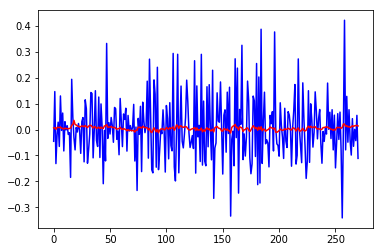

In [75]:
import matplotlib.pyplot as plt
# We plot the ground-truth values in blue and the predicted values in red:
plt.plot(y_test_vals, color = "blue")
plt.plot(predictions, color = "red")


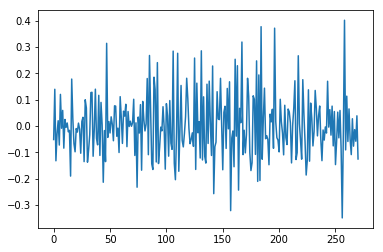

In [76]:
# We plot the difference between our model's predictions and the actual values:
plt.plot(y_test_vals - predictions)

In [77]:
from sklearn.linear_model import ElasticNet
